# 1. Data processing

### 1.1<u>Get Data</u>

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


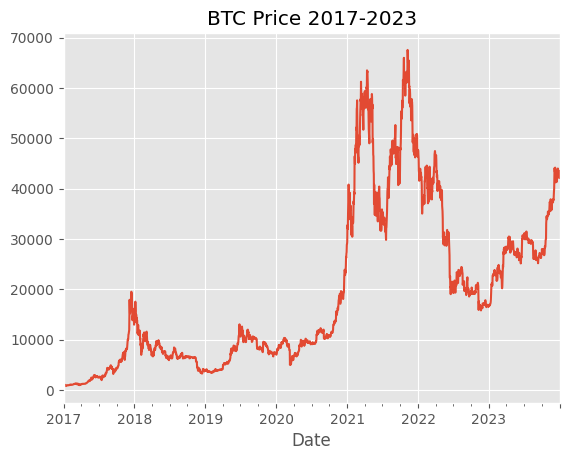

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# Get stock data
df = yf.download("BTC-USD", start="2017-1-1", end="2024-1-1", interval="1d")
plt.style.use('ggplot')
df['Close'].plot(label='Close', title='BTC Price 2017-2023')

df.head(5)

### 1.2 <u>Process Data</u>

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])

    return np.array(X), np.array(y)

# Get list of closing prices
data = list(df.iloc[:, 3])

# Reshape price data to be 2D -> required by MinMaxScaler
data = np.array(data).reshape(-1, 1)

seq_length = 60

# X, y = create_dataset(data_normalized, seq_length)
X, y = create_dataset(data, seq_length)

### 1.3 <u>Create training and test set</u>

In [3]:
import random
import torch

test_indexes  = random.sample(range(len(X)), 300)
train_indexes = [i for i in range(len(X)) if i not in test_indexes]

X_test = torch.tensor(X[test_indexes], dtype=torch.float32)
y_test = torch.tensor(y[test_indexes], dtype=torch.float32)

X_train = torch.tensor(X[train_indexes], dtype=torch.float32)
y_train = torch.tensor(y[train_indexes], dtype=torch.float32)

# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reshape X,y into (nr_of_samples, seq_length, nr_of_features) -> necessary for LSTM
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))       #.to(device)
y_test = torch.reshape(y_test, (y_test.shape[0], 1, 1))                     #.to(device)

X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   #.to(device)
y_train = torch.reshape(y_train, (y_train.shape[0], 1, 1))                  #.to(device)

/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# 2. LSTM

In [12]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, fc_features):
        super(LSTM, self).__init__()

        self.num_classes    = num_classes
        self.input_size     = input_size
        self.hidden_size    = hidden_size
        self.num_layers     = num_layers
        self.seq_length     = seq_length

        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size, 
                            num_layers = self.num_layers, 
                            batch_first = True) 
        
        self.fc1 = nn.Linear(self.hidden_size, fc_features)
        self.fc2 = nn.Linear(fc_features, self.num_classes)

        self.relu = nn.ReLU()

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)

        output, (hn, cn) = self.lstm(X, (h0, c0))

        # hn = hn.view(-1, self.hidden_size)

        # Use the hidden state from the last LSTM layer
        hn = hn[-1]  # Now hn has shape (batch_size, hidden_size)

        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

# 3. Training

In [5]:
from sklearn.model_selection import KFold
from torch.amp import GradScaler

# HYPERPARAMETERS
NUM_EPOCHS      = 1000
LEARNING_RATE   = 0.001
HIDDEN_SIZE     = 32

# Enable cuDNN autotuner for GPU accelerations
torch.backends.cudnn.benchmark = True

# Parameters
input_size  = 1      # Number of input features
num_classes = 1     # Number of output classes -> 1, because it needs to output 1 value

# Hyperparameters
num_epochs      = 60
learning_rate   = 0.001

hidden_size     = 32        # Number of features in hidden state
fc_features     = 128       # Size of output of first fully connected layer
num_layers      = 2         # Number of stacked lstm layers

batch_size = 5

# Set loss function to MSE loss
criterion = nn.MSELoss()

nr_folds = 10
kf = KFold(n_splits = nr_folds)

# Initialize gradscaler (AMP) -> gpu accelerations
scaler = GradScaler()

/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [6]:
# Initialize scalers
feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()


def normalize(X, y, train_indices, test_indices):
    # Create train and test set
    X_train_fold, y_train_fold = X[train_indices], y[train_indices]
    X_test_fold, y_test_fold = X[test_indices], y[test_indices]

    # Reshape training data to 2D for normalization
    X_train_reshaped = X_train_fold.reshape(-1, X_train_fold.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)
    y_train_reshaped = y_train_fold.reshape(-1, y_train_fold.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)

    # Fit the scaler on the training data
    X_train_normalized = feature_scaler.fit_transform(X_train_reshaped)
    y_train_normalized = label_scaler.fit_transform(y_train_reshaped)

    # Reshape back to 3D
    X_train_normalized = X_train_normalized.reshape(X_train_fold.shape)
    y_train_normalized = y_train_normalized.reshape(y_train_fold.shape)

    # Normalize the test data using the fitted scaler from the training data
    X_test_reshaped = X_test_fold.reshape(-1, X_test_fold.shape[-1])
    y_test_reshaped = y_test_fold.reshape(-1, y_test_fold.shape[-1])

    X_test_normalized = feature_scaler.transform(X_test_reshaped)
    y_test_normalized = label_scaler.transform(y_test_reshaped)

    # Reshape back to 3D
    X_test_normalized = X_test_normalized.reshape(X_test_fold.shape)
    y_test_normalized = y_test_normalized.reshape(y_test_fold.shape)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

def normalize_test(X, y):
    # Normalize the test data using the fitted scaler from the training data
    X_test_reshaped = X.reshape(-1, X.shape[-1])
    y_test_reshaped = y.reshape(-1, y.shape[-1])

    X_test_normalized = feature_scaler.transform(X_test_reshaped)
    y_test_normalized = label_scaler.transform(y_test_reshaped)

    # Reshape back to 3D
    X_test_normalized = X_test_normalized.reshape(X.shape)
    y_test_normalized = y_test_normalized.reshape(y.shape)

    X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

    return X_test_tensor, y_test_tensor


In [8]:
class ModelInfo():
    def __init__(self):
        self.inputs     = []
        self.labels     = []
        self.outputs    = []
        self.loss       = float()
        self.model      = None

In [13]:
from torch.utils.data import Subset, DataLoader, TensorDataset
from torch.amp import autocast
import copy

results = {i:ModelInfo() for i in range(nr_folds)}
for i in range(nr_folds): results[i].loss = np.inf

for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    print(f'----------\nFOLD {fold}')

    # Normalize dataset -> must be done for individual folds to prevent data leakage
    X_train_fold, y_train_fold, X_val_fold, y_val_fold = normalize(X_train, y_train, train_indices, val_indices)

    # Combine inputs and labels
    train_dataset_fold  = TensorDataset(X_train_fold, y_train_fold)
    val_dataset_fold    = TensorDataset(X_val_fold, y_val_fold)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    val_loader   = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

    # Create LSTM object and move it to the GPU
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], fc_features).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    epochs_wo_improvement = 0
    for epoch in range(num_epochs):
        if epochs_wo_improvement > 20:
            print('early stopping!')
            break

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            targets = targets.reshape(targets.shape[0],1)

            inputs  = inputs.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            with autocast(device_type="cuda"):
                # Forward pass
                outputs = lstm.forward(inputs)
                # Compute loss
                loss = criterion(outputs, targets)

            # Unscales gradients and calls or skips optimizer.step()
            scaler.scale(loss).backward()

            # Unscales gradients and calls or skips optimizer.step()
            scaler.step(optimizer)
            
            # Updates the scale for next iteration
            scaler.update()

        val_results = ModelInfo()
        val_results.model = lstm.state_dict()
        with torch.no_grad():
            for i, val_data in enumerate(val_loader, 0):
                val_inputs, val_targets = val_data
                val_targets = val_targets.reshape(val_targets.shape[0], 1)

                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)

                val_outputs = lstm.forward(val_inputs)
                val_loss = criterion(val_outputs, val_targets)

                for i in range(val_inputs.shape[0]):
                    single_input = val_inputs[i].flatten()
                    single_label = val_targets[i]
                    single_output = val_outputs[i]

                    val_results.inputs.append(single_input)
                    val_results.labels.append(single_label)
                    val_results.outputs.append(single_output)

                val_results.loss += float(val_loss.item())
        val_results.loss /= len(val_loader)

        if results[fold].loss > val_results.loss:
            results[fold] = copy.copy(val_results)
            print(f'epoch {epoch} | validation loss: {val_results.loss} | new best model!')
            epochs_wo_improvement = 0
        else:
            print(f'epoch {epoch} | validation loss: {val_results.loss}')
            epochs_wo_improvement += 1



    X_test_norm, y_test_norm = normalize_test(X_test, y_test)

    lstm_test = LSTM(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], fc_features).to(device)

    lstm_test.load_state_dict(results[fold].model)

    # Set the model to evaluation mode
    lstm_test.eval()

    X_test_norm = X_test_norm.to(device)
    test_output = lstm_test.forward(X_test_norm).to(device)

    test_output_np = test_output.cpu().data.numpy()
    test_labels_np = y_test_norm.data.numpy()
    test_labels_np = test_labels_np.reshape(test_labels_np.shape[0], 1)

    X_plot = feature_scaler.inverse_transform(test_output_np)
    y_plot = feature_scaler.inverse_transform(test_labels_np)

    errors = np.abs(X_plot - y_plot)
    avg_error = np.mean(errors)
    print(f'Average test error: {avg_error}\n')

    plt.scatter(np.arange(len(errors)), errors)



----------
FOLD 0


hn shape: torch.Size([2, 5, 32])
tensor([[[-0.0434,  0.0227, -0.0614, -0.0608,  0.0814,  0.0357, -0.0623,
          -0.0597,  0.0263,  0.0645,  0.0404,  0.0364, -0.0295, -0.0668,
           0.0645,  0.0657,  0.1214,  0.0276,  0.1714, -0.0100, -0.0133,
          -0.0225, -0.0559, -0.0365, -0.0543,  0.0863,  0.0752,  0.0071,
          -0.0253,  0.1159,  0.0511, -0.0646],
         [-0.0509,  0.0165, -0.0403, -0.0088,  0.0976,  0.0671, -0.0504,
          -0.0788,  0.0057,  0.0999,  0.0580,  0.0304, -0.0570, -0.0960,
           0.0269,  0.0923,  0.1360,  0.0054,  0.1786, -0.0051, -0.0308,
          -0.0471, -0.0201, -0.0391, -0.0390,  0.0553,  0.0789,  0.0402,
          -0.0056,  0.1074,  0.0576, -0.0486],
         [-0.0413,  0.0247, -0.0669, -0.0747,  0.0767,  0.0274, -0.0657,
          -0.0542,  0.0317,  0.0548,  0.0357,  0.0380, -0.0223, -0.0586,
           0.0749,  0.0585,  0.1173,  0.0328,  0.1700, -0.0115, -0.0087,
          -0.0159, -0.0652, -0.0360, -0.0588,  0.0944,  0.0741, -0.001

/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


hn shape: torch.Size([2, 5, 32])
tensor([[[-5.3162e-02,  1.1899e-02, -7.5528e-02, -8.7534e-02,  8.9714e-02,
           1.5400e-02, -5.0059e-02, -4.2268e-02,  2.0858e-02,  6.7041e-02,
           2.9357e-02,  4.9223e-02, -9.7762e-03, -7.1514e-02,  7.7300e-02,
           7.4658e-02,  1.0366e-01,  4.4381e-02,  1.7528e-01, -1.7455e-02,
          -9.2708e-03, -6.6212e-03, -4.2355e-02, -2.2910e-02, -6.7856e-02,
           8.1398e-02,  9.5539e-02,  1.1535e-02, -3.6517e-02,  1.3378e-01,
           6.2932e-02, -7.9234e-02],
         [-6.0637e-02,  5.4230e-03, -6.1404e-02, -4.9896e-02,  1.0400e-01,
           3.6846e-02, -3.9264e-02, -5.4959e-02,  3.9151e-03,  9.5490e-02,
           4.1563e-02,  4.6381e-02, -2.8147e-02, -9.6377e-02,  4.9925e-02,
           9.7702e-02,  1.1335e-01,  3.0763e-02,  1.8165e-01, -1.4132e-02,
          -2.1694e-02, -2.3708e-02, -1.2911e-02, -2.2875e-02, -5.5742e-02,
           5.7368e-02,  1.0142e-01,  3.9236e-02, -2.1494e-02,  1.2916e-01,
           6.9343e-02, -6.7971

KeyboardInterrupt: 

In [ ]:
class ModelInfo():
    def __init__(self):
        self.inputs     = []
        self.labels     = []
        self.outputs    = []
        self.loss       = float()
        self.model      = None

ola


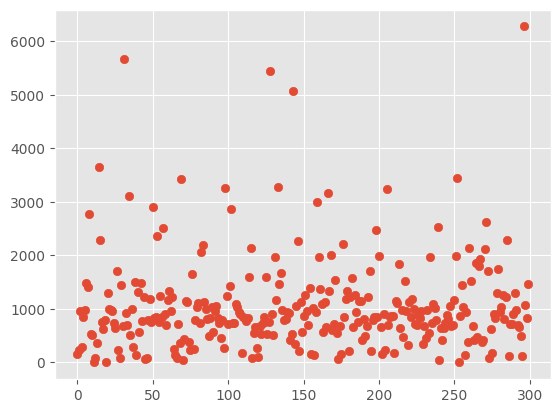

In [ ]:
def normalize_test(X, y):
    # Normalize the test data using the fitted scaler from the training data
    X_test_reshaped = X.reshape(-1, X.shape[-1])
    y_test_reshaped = y.reshape(-1, y.shape[-1])

    X_test_normalized = feature_scaler.transform(X_test_reshaped)
    y_test_normalized = label_scaler.transform(y_test_reshaped)

    # Reshape back to 3D
    X_test_normalized = X_test_normalized.reshape(X.shape)
    y_test_normalized = y_test_normalized.reshape(y.shape)

    X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

    return X_test_tensor, y_test_tensor

X_test_norm, y_test_norm = normalize_test(X_test, y_test)

lstm_test = LSTM(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], fc_features).to(device)

lstm_test.load_state_dict(results[0].model)

# Set the model to evaluation mode
lstm_test.eval()

X_test_norm = X_test_norm.to(device)
test_output = lstm_test.forward(X_test_norm).to(device)

test_output_np = test_output.cpu().data.numpy()
test_labels_np = y_test_norm.data.numpy()
test_labels_np = test_labels_np.reshape(test_labels_np.shape[0], 1)

X_plot = feature_scaler.inverse_transform(test_output_np)
y_plot = feature_scaler.inverse_transform(test_labels_np)

errors = np.abs(X_plot - y_plot)
avg_error = np.mean(errors)

plt.scatter(np.arange(len(errors)), errors)


[tensor([-0.0335, -0.0331, -0.0328, -0.0311, -0.0332, -0.0350, -0.0349, -0.0348,
         -0.0350, -0.0349, -0.0369, -0.0365, -0.0362, -0.0363, -0.0362, -0.0361,
         -0.0349, -0.0352, -0.0350, -0.0351, -0.0347, -0.0346, -0.0347, -0.0351,
         -0.0350, -0.0347, -0.0347, -0.0347, -0.0347, -0.0347], device='cuda:0'),
 tensor([-0.0331, -0.0328, -0.0311, -0.0332, -0.0350, -0.0349, -0.0348, -0.0350,
         -0.0349, -0.0369, -0.0365, -0.0362, -0.0363, -0.0362, -0.0361, -0.0349,
         -0.0352, -0.0350, -0.0351, -0.0347, -0.0346, -0.0347, -0.0351, -0.0350,
         -0.0347, -0.0347, -0.0347, -0.0347, -0.0347, -0.0339], device='cuda:0'),
 tensor([-0.0328, -0.0311, -0.0332, -0.0350, -0.0349, -0.0348, -0.0350, -0.0349,
         -0.0369, -0.0365, -0.0362, -0.0363, -0.0362, -0.0361, -0.0349, -0.0352,
         -0.0350, -0.0351, -0.0347, -0.0346, -0.0347, -0.0351, -0.0350, -0.0347,
         -0.0347, -0.0347, -0.0347, -0.0347, -0.0339, -0.0336], device='cuda:0'),
 tensor([-0.0311, -0.0332